#  Прогнозирование заказов такси

## Подготовка

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose

Чтобы преобразовать нужный столбец в датасете в тип данных datetime, передадим в функцию read_csv аргумент parse_dates. Индексировать данные будем по первому столбцу.

In [4]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
display(taxi.info())
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Наблюдения в датасете сделаны с разницей в 10 минут. Это слишком подробные данные. Выполним ресемплирование с интервалом в 1 час. Данные суммируем.

In [5]:
taxi.sort_index(inplace=True)
taxi = taxi.resample('1H').sum()

In [6]:
display(taxi.info())
taxi.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Изучим данные,в какой промежуток времени велось наблюдение.

In [7]:
print("Начало наблюдения:", taxi.index.min())
print("Конец наблюдения:", taxi.index.max())

Начало наблюдения: 2018-03-01 00:00:00
Конец наблюдения: 2018-08-31 23:00:00


Нам предоставлены данные с марта по август (включительно) 2018 года.

Оценим данные на графике.

<AxesSubplot:xlabel='datetime'>

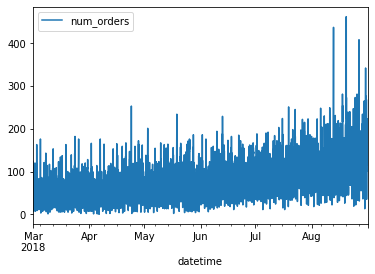

In [8]:
taxi.plot()

Мы не сможем изучить сезонность по предоставленным данным, так как информация есть только по срезу в полгода. Но можем оценить, как меняется объем заказов от первого наблюдения к последнему. Для наглядности ресемплируем данные по неделе и сохраним с новую переменную. Выведем на график.

<AxesSubplot:xlabel='datetime'>

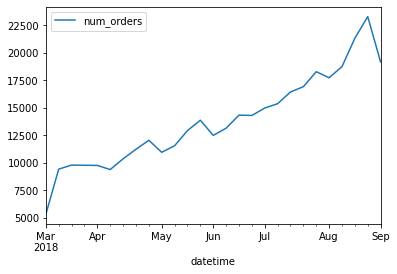

In [9]:
taxi_week = taxi.resample('1W').sum()
taxi_week.plot()

По графику можно сказать, что дела у сервиса по заказу такси идут хорошо - заказы увеличиваются от месяца к месяцу. Однако, однозначного решения принять нельзя - возможно, это стандартная практика у сервисов, и если бы мы взглянули на данные за несколько лет, то проследили бы закономерность.

С помощью функции seasonal_decompose() разложим временной ряд на три составляющие: тренд, сезонность и остаток (residuals) - это шум, который не объясняется трендом и сезонностью.

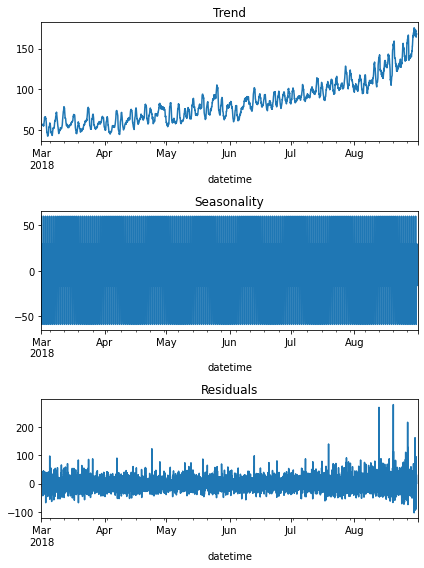

In [10]:
decomposed = seasonal_decompose(taxi['num_orders'], model='additive')

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Здесь также видно, что тренд растет от месяца к месяцу, но чтобы вывести сезонность нагляднее и изучить ее, ресемплируем данные по одному дню.

Text(0.5, 1.0, 'Seasonality')

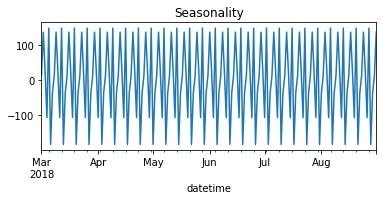

In [11]:
taxi_day = taxi.resample('1D').sum()

decomposed_day = seasonal_decompose(taxi_day)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

Видим колебания раз в неделю - похоже, на выходных услугами такси пользуются реже. Логично - люди больше выезжают за город на личном транспорте,гуляют пешком,остаются дома.

Найдем разности временного ряда. Станет ли он более стационарным, если применить метод .shift()

<AxesSubplot:xlabel='datetime'>

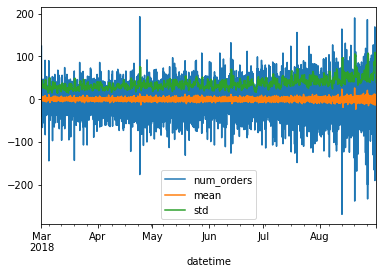

In [12]:
taxi_shifted = taxi - taxi.shift(fill_value=0)
taxi_shifted['mean'] = taxi_shifted['num_orders'].rolling(15).mean()
taxi_shifted['std'] = taxi_shifted['num_orders'].rolling(15).std()
taxi_shifted.plot()

Ряд становится более стационарным, а значит данные можно прогнозировать.

## Обучение

Для успешного обучения добавим признаки в датасет. Напишем функцию make_features(), которая:

+ добавит к датасету четыре новых календарных признака: год, месяц, день и день недели,
+ вычислит и добавит отстающие значения (предыдущие значения временного ряда, которые покажут, будет ли функция x(t) расти или уменьшаться),
+ вычислит скользящее среднее и добавит его как признак rolling_mean - этот признак задаст общий тренд временного ряда.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [14]:
make_features(taxi, 24, 3)
taxi.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.333333
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.000000


Разделим данные на обучающую и тестовую выборки, а затем поделим признаки.

Функция train_test_split по умолчанию перемешивает данные (что нам в данном случае не нужно), поэтому добавим параметр shuffle=False.

После применения функции make_features у нас появились NaN-значения за счет сдвига данных. Их никак не заполнить - просто избавимся от них.

In [15]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Проверим, что данные не перемешались - сравним последнее наблюдение признаков обучающей выборки и первое наблюдение признаков тестовой выборки.

In [16]:
print(features_train.index[features_train.shape[0]-1])
print(features_test.index[0])

2018-08-13 13:00:00
2018-08-13 14:00:00


<div class="alert alert-block alert-success">
<b>Успех:</b> Разбиение было сделано верно.
</div>

Все верно, данные можно использовать для обучения.

In [17]:
#напишем формулу для получения значения метрики RMSE
def rmse (target, predictions):
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    return rmse

Обучим модели LinearRegression, CatBoostRegressor и LGBMRegressor.

# LinearRegression

In [18]:
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
predicted_lr = pd.Series(lr_model.predict(features_test))

# CatBoostRegressor

In [102]:
cat_model = CatBoostRegressor(random_state=12345)
hyperparams = [{'depth' : [7], #брал 1, 2, 3, 5 ,7
                'learning_rate' : [0.1], #брал 0.03, 0.06, 0.1
                'iterations' : [150], #брал 100, 200, 300
                'verbose' : [10]
               }]
cat_cv = TimeSeriesSplit(n_splits=3).split(features_train)
clf = GridSearchCV(cat_model, hyperparams, cv=cat_cv, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
best_params_CBR = clf.best_params_
print(best_params_CBR)
print((clf.best_score_*-1)**0.5)

0:	learn: 28.1866683	total: 12.9ms	remaining: 1.93s
10:	learn: 20.4651653	total: 91.7ms	remaining: 1.16s
20:	learn: 17.5492230	total: 163ms	remaining: 1s
30:	learn: 15.9422178	total: 237ms	remaining: 910ms
40:	learn: 14.7083208	total: 311ms	remaining: 828ms
50:	learn: 13.9328960	total: 389ms	remaining: 755ms
60:	learn: 13.2353952	total: 483ms	remaining: 704ms
70:	learn: 12.5620886	total: 581ms	remaining: 647ms
80:	learn: 12.0793023	total: 671ms	remaining: 572ms
90:	learn: 11.3542471	total: 770ms	remaining: 499ms
100:	learn: 10.7667230	total: 865ms	remaining: 419ms
110:	learn: 10.2961961	total: 955ms	remaining: 335ms
120:	learn: 9.8219435	total: 1.03s	remaining: 247ms
130:	learn: 9.3922616	total: 1.12s	remaining: 162ms
140:	learn: 8.9012158	total: 1.2s	remaining: 76.3ms
149:	learn: 8.4588275	total: 1.26s	remaining: 0us
0:	learn: 30.5200801	total: 8.86ms	remaining: 1.32s
10:	learn: 22.5215061	total: 97.2ms	remaining: 1.23s
20:	learn: 19.6009343	total: 198ms	remaining: 1.22s
30:	learn: 18

In [103]:
cat_model = CatBoostRegressor(depth = 7, iterations = 150, learning_rate = 0.1, verbose= 10)
cat_model.fit(features_train, target_train)
predicted_cat = cat_model.predict(features_test)

0:	learn: 36.9206903	total: 10.9ms	remaining: 1.62s
10:	learn: 27.5280309	total: 134ms	remaining: 1.69s
20:	learn: 24.4764472	total: 253ms	remaining: 1.55s
30:	learn: 23.0413681	total: 394ms	remaining: 1.51s
40:	learn: 22.2425465	total: 547ms	remaining: 1.46s
50:	learn: 21.6791023	total: 678ms	remaining: 1.32s
60:	learn: 21.2166660	total: 811ms	remaining: 1.18s
70:	learn: 20.6914608	total: 935ms	remaining: 1.04s
80:	learn: 20.1799670	total: 1.06s	remaining: 904ms
90:	learn: 19.7367389	total: 1.18s	remaining: 767ms
100:	learn: 19.2510535	total: 1.3s	remaining: 633ms
110:	learn: 18.7704168	total: 1.43s	remaining: 502ms
120:	learn: 18.2134620	total: 1.56s	remaining: 373ms
130:	learn: 17.7964812	total: 1.71s	remaining: 248ms
140:	learn: 17.3297260	total: 1.85s	remaining: 118ms
149:	learn: 16.9352298	total: 1.96s	remaining: 0us


# LGBMRegressor

In [47]:
lgbmmodel = LGBMRegressor(learning_rate=0.1,num_leaves=100, random_state=12345,max_depth=6)
lgbmmodel.fit(features_train, target_train)
predicted_lgbm = lgbmmodel.predict(features_test)

## Тестирование

# LinearRegression

45.291905478214076


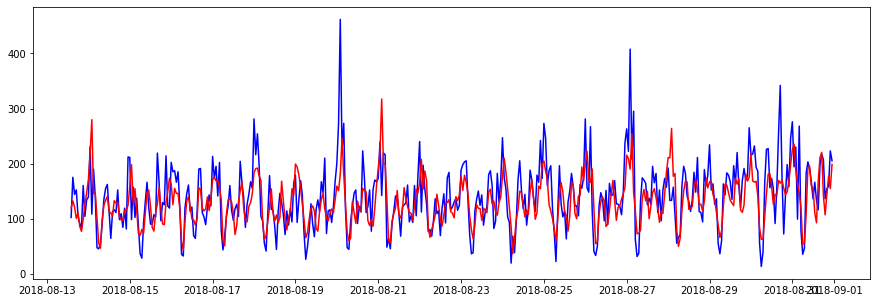

In [86]:
print(rmse(target_test, predicted_lr))
plt.figure(figsize=(15,5))
plt.plot(target_test.index, target_test, 'b-', target_test.index, predicted_lr,'r-')

# CatBoostRegressor

42.594501080092755


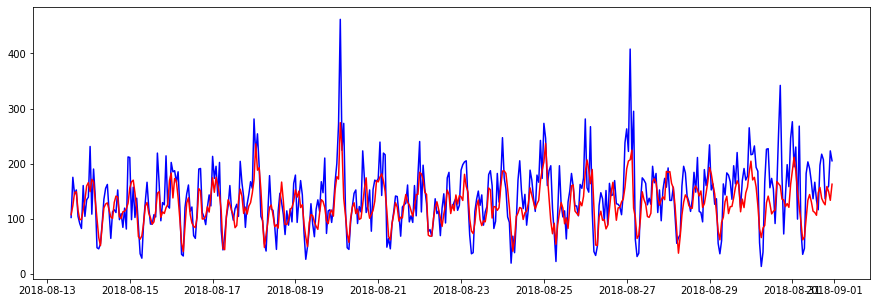

In [104]:
print(rmse(target_test, predicted_cat))
plt.figure(figsize=(15,5))
plt.plot(target_test.index, target_test, 'b-', target_test.index, predicted_cat,'r-')

# LGBMRegressor

41.63374909430713


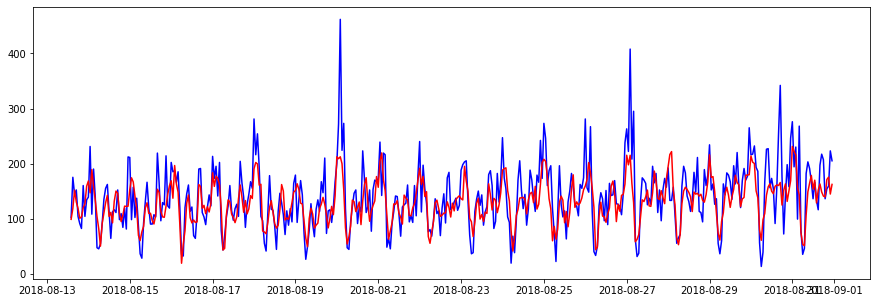

In [62]:
print(rmse(target_test, predicted_lgbm))
plt.figure(figsize=(15,5))
plt.plot(target_test.index, target_test, 'b-', target_test.index, predicted_lgbm,'r-')

# Вывод
Лучший результат показала модель LGBMRegressor , как прототип сервису такси можно советовать её. немного уступает CatBoostRegressor. LinearRegression показала худший результат.